In [2]:
import torch
from pathlib import Path
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

from vap.data.dset_event import VAPClassificationDataset
from vap.eval_events import plot_accuracy_now_vs_fut
from vap.utils.utils import read_json
from vap.utils.plot import plot_melspectrogram, plot_vap_probs, plot_vad
from vap.modules.lightning_module import VAPModule, VAP, everything_deterministic

everything_deterministic()

In [3]:
DIR_PATH = "../data/results/classification/epoch=10-step=43966"
metadata = read_json(join(DIR_PATH, 'metadata.json'))

# Should use full paths
metadata['csv'] = join('..', metadata['csv'])
metadata['checkpoint'] = join('..', metadata['checkpoint'])

# Load results
df = pd.read_csv(join(DIR_PATH, 'predictions.csv'))
af = pd.read_csv(join(DIR_PATH, 'accuracy.csv'))
metadata

{'checkpoint': '../runs_new/VAP2/4h9zaesr/checkpoints/epoch=10-step=43966.ckpt',
 'csv': '../data/splits_twilio/val_hs.csv',
 'output_dir': 'data/results/classification/epoch=10-step=43966',
 'plot': False,
 'context': 20,
 'region_sil_pad_time': 0.2,
 'region_duration': 0.2,
 'post_silence': 1.0,
 'min_event_silence': 0,
 'batch_size': 100,
 'num_workers': 26,
 'prefetch_factor': None,
 'events_total': 23507,
 'events_shift': 0.4494831326838814,
 'events_hold': 0.5505168673161186}

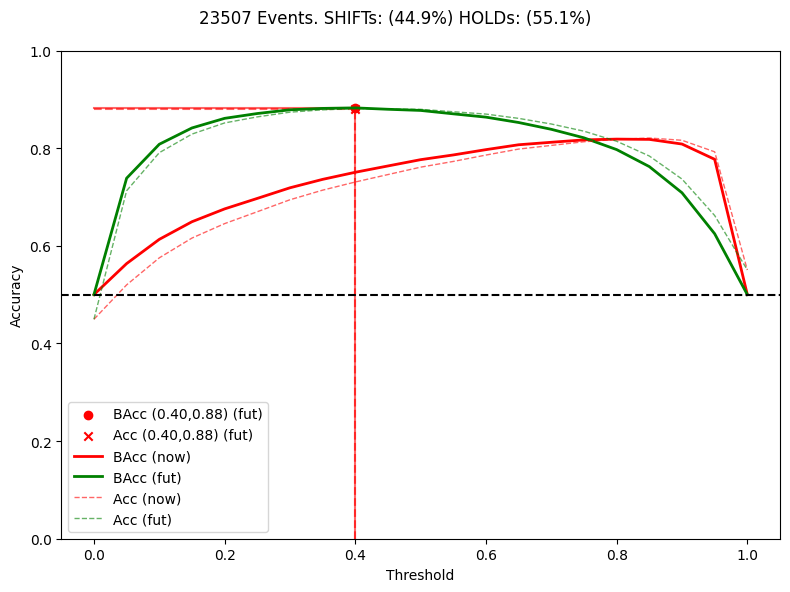

In [4]:
N = {'total': metadata['events_total'], 'shift': metadata['events_shift'], 'hold': 1-metadata['events_shift']}
fig, ax = plot_accuracy_now_vs_fut(af, N=N)

# Model Output

Look at the actual output from the model over random samples from the data.

In [5]:
def plot_output(d, out, height_ratios=[2, 2, 1, 1, 1, 1], frame_hz:int=50):
    # Create the figure and the GridSpec instance with the given height ratios
    fig, ax = plt.subplots(
        nrows=6,
        sharex=True,
        figsize=(15, 6),
        gridspec_kw={"height_ratios": height_ratios, "hspace": 0.01},
    )
    plot_melspectrogram(d["waveform"], ax=ax[:2])
    # plot vad.
    x2 = torch.arange(out["vad"].shape[1]) / frame_hz
    plot_vad(x2, out["vad"][0, :, 0], ax[0], ypad=3, color="w", label="VAD pred")
    plot_vad(x2, out["vad"][0, :, 1], ax[1], ypad=3, color="w", label="VAD pred")
    for i in range(4):
        plot_vap_probs(out["p"][i, 0], ax=ax[2 + i])
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[0].legend()
    ax[1].legend()
    ax[-1].set_xticks(list(range(0, 1 + round(x2[-1].item()))))  # list(range(0, 20)))
    ax[-1].set_xlabel("Time (s)")
    return fig, ax

def plot_event_region(start, end, d, ax):
    if d['label'] == 'shift':
        if d['speaker'] == 0:
            color = 'orange'
        else:
            color = 'blue'
    else:
        if d['speaker'] == 0:
            color = 'blue'
        else:
            color = 'orange'
    for a in ax:
        a.axvline(start, color=color)
        a.axvline(end, color=color)

In [6]:
model = VAPModule.load_model(metadata['checkpoint'])
dset = VAPClassificationDataset(
        df_path=metadata['csv'],
        context=metadata['context'],
        post_silence=metadata['post_silence'],
        min_event_silence=0,
    )
region_start_time = metadata['context'] + metadata['region_sil_pad_time']
region_end_time = region_start_time + metadata['region_duration']

/home/ubuntu/miniconda3/envs/vap/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


Label:  hold
P-now:  0.746
P-fut:  0.055
P-1:  0.725
P-2:  0.756
P-3:  0.082
P-4:  0.035


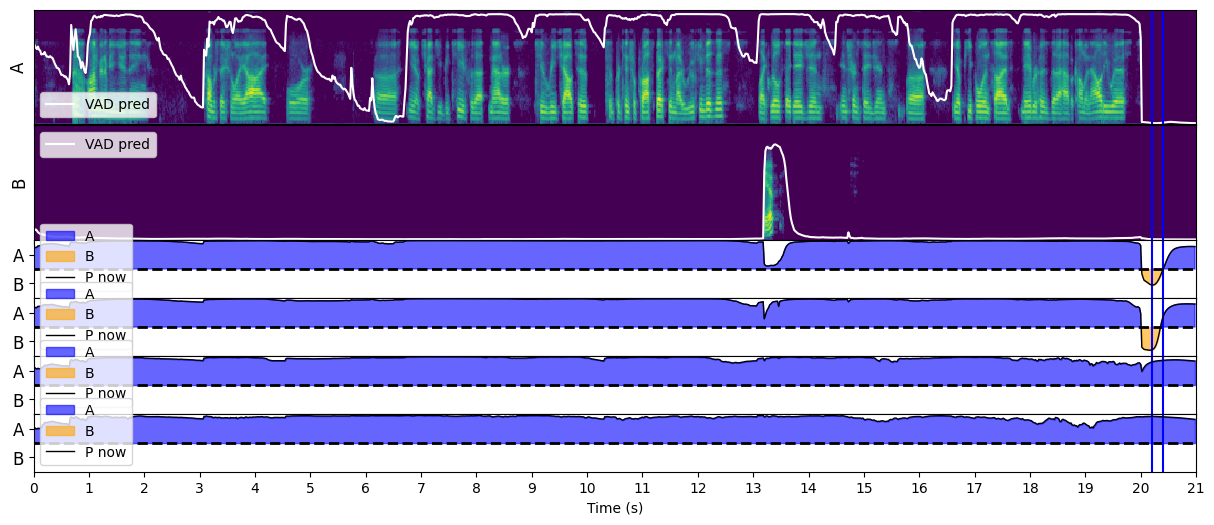

In [20]:
idx = torch.randint(0, len(dset), (1,)).item()
d = dset[idx]
with torch.inference_mode():
    out = model.probs(d['waveform'].unsqueeze(0).to(model.device))
    preds = model.get_shift_probability(
            out, region_start_time, region_end_time, d["speaker"]
        )

fig, ax = plot_output(d, out)
plot_event_region(region_start_time, region_end_time, d, ax)
print('Label: ', d['label'])
print('P-now: ', round(preds['p_now'][0], 3))
print('P-fut: ', round(preds['p_fut'][0], 3))
print('P-1: ', round(preds['p1'][0], 3))
print('P-2: ', round(preds['p2'][0], 3))
print('P-3: ', round(preds['p3'][0], 3))
print('P-4: ', round(preds['p4'][0], 3))